# Assignment - 2: Data Representation and Point Cloud Operations

Team Name: Vision 

Roll number: 2021701002, 2021702011

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- The **References** section provides you with important resources to solve the assignment.
- Make sure your code is modular since you may need to reuse parts for future assignments.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- The **deadline** for this assignment is on 26/09/2021 at 11:55pm. Please note that there will be no extensions.
- Plagiarism is **strictly prohibited**.

# Submission Instructions

1. Make sure your code runs without any errors after reinitializing the kernel and removing all saved variables.
2. After completing your code and saving your results, zip the folder with name as ``Team_<team_name>_MR2021_Assignment_<assignment_number>.zip``

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os

# Introduction to types of Transformations and Homogeneous coordinates

In robotics applications, it is inevitable to keep track of the frames of multiple objects/worlds. These frames can be transformations from one coordinate frame to the other. **Homogeneous coordinates** help in keeping track of various coordinate frames and allow performing composition of various transforms. We will first try to understand between types of transformations and their invariant properties.
1. What is the difference between Affine, Similarity, and Euclidean transform? What are the invariant properities of each type of transform?

__Ans:__ In affine transformations the linear proportions are preserved but not the angles which means that the distance between the points on a line can change without changing how they are positioned,whereas in similarity transformation linear proportions along with the included angles are preserved.In Euclidean or rigid transformations lengths and the included angles remain as they are.

Let p,q be the positional vectors and E,F,G be the affine,similarity,Euclidean transforms of p,q respectively,then

|p-q| / |E(p)-E(q)| = r for affine transformations

|p-q| / |F(p)-F(q)| = r and (p/|p|) x (q/|q|) = (F(p) / |F(p)|) x (F(q) / |F(q)|) for similarity transformation

|p-q| = G(p)-G(q) and p x q = G(p) x G(q) for Euclidean transformation

2. Watch this [video](https://www.youtube.com/watch?v=PvEl63t-opM) to briefly understand homogeneous coordinates. What are points at infinity? What type of transformation can you apply to transform a point from infinity to a point that is not at infinity? 

__Ans:__ The points at the horizon of the camera view are actually the points at infinity which are transformed to the horizon by using homogeneous coordinates.This can be represented by an affine transformation as the line of view from the camera to the points at infinity are scaled down so that they can be seen near at the horizon and the angles included also change as 2 planes meeting at infinity in 3D coordinate system now have to meet at a relatively nearer horizon in the homogeneous coordinate system.

3. Using homogeneous coordinates we can represent different types of transformation as point transforms vs. frame transforms. Concatenation of transforms (whether you post multiply transformation matrices or pre-multiply transformation matrices) depends on the problem and how you are viewing it. Try to understand the difference between frame vs. point transformations from this [video](https://youtu.be/Za7Sdegf8m8?t=1834). Let's assume that our camera and world frames are coinciding with each other. We need to estimate the camera to world **frame** transformation matrix after applying the transformations defined below in terms of $T_i$.We apply **frame** transform to move the camera in the world in the following order:
    1. $T_1$ from the camera coordinate frame.
    2. $T_2$ from the world coordinate frame.
    3. $T_3$ from the world coordinate frame.
    4. $T_4$ from the camera coordinate frame.
    5. $T_5$ from the camera coordinate frame.

__Ans:__ The point to be noted here is that the transformations with respect to the world frame and body fixed frame are to be premultiplied and post multiplied respectively to the series of happened transformations. In this way the final transformation matrix after the transforms given as per A,B,C,D,E in series can be written as [[T3 x [T2 x [Ti x T1]]] x T4] x T5

# Visualise the Data

Point clouds are a collection of points that represent a 3D shape or feature. Each point has its own set of X, Y and Z coordinates and in some cases additional attributes. A popular way to obtain this is by photogrammetry, though here we will use LiDAR data.

LiDAR is a remote sensing process which collects measurements used to create 3D models and maps of objects and environments. Using ultraviolet, visible, or near-infrared light, LiDAR gauges spatial relationships and shapes by measuring the time it takes for signals to bounce off objects and return to the scanner.

1. Download the data from [here](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/venkata_surya_students_iiit_ac_in/EnYAMaTVIhJItzKYqtahE30BRKB6p6UfHN3TyJzvo6Mw0g?e=PegWds). It contains the LIDAR sensor output and odometry information per frame.

    The .bin files contain the 3D point cloud captured by the LIDAR in this format - x, y, z, and reflectance. 

    The odometry information is given in the `odometry.txt` file, which is a 12 element vector. Reshape each of the first 77 rows to a 3x4 matrix to obtain the pose.
    

2. Obtain the point cloud from this and visualise for 1-2 frames.

In [2]:
def getPoseMatricesFromOdometry(odometry_path, k):
    odometry = np.loadtxt(odometry_path)
    # print(odometry.shape)
    return odometry[0:k].reshape(k,3,4)

In [3]:
pose_matrices = getPoseMatricesFromOdometry("data/odometry.txt", 77)

pose_matrices

array([[[ 1.000000e+00,  9.043683e-12,  2.326809e-11,  1.110223e-16],
        [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  2.220446e-16],
        [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -2.220446e-16]],

       [[ 9.990498e-01, -1.649780e-03,  4.355194e-02,  5.154656e-02],
        [ 1.760423e-03,  9.999953e-01, -2.502237e-03, -2.424883e-02],
        [-4.354760e-02,  2.576529e-03,  9.990480e-01,  1.000725e+00]],

       [[ 9.960495e-01, -5.367949e-03,  8.863831e-02,  1.464632e-01],
        [ 6.010224e-03,  9.999575e-01, -6.980718e-03, -5.051622e-02],
        [-8.859707e-02,  7.485875e-03,  9.960394e-01,  1.995659e+00]],

       [[ 9.909271e-01, -5.886878e-03,  1.342721e-01,  2.879204e-01],
        [ 7.448178e-03,  9.999103e-01, -1.112852e-02, -7.903059e-02],
        [-1.341946e-01,  1.202763e-02,  9.908820e-01,  2.986691e+00]],

       [[ 9.836222e-01, -3.565066e-03,  1.802072e-01,  4.657503e-01],
        [ 6.172884e-03,  9.998841e-01, -1.391250e-02, -1.102928e-01],
        [-1.

In [4]:
path = "data/LiDAR/"
bins_list = os.listdir(path)

point_clouds = []
for bin in (bins_list):
    lidar_data = np.fromfile((path + bin), dtype=np.float32)
    lidar_data = lidar_data.reshape(-1,4)
    
    lidar_points = lidar_data.reshape(-1,4)[:, 0:3]
#     lidar_colors = lidar_data[:, 3]
#     lidar_colors = np.tile(lidar_colors, (3,1)).T

    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(lidar_points))
#     pcd.colors = o3d.utility.Vector3dVector(lidar_colors)
    
    point_clouds.append(pcd)

In [5]:
print(point_clouds[0])
o3d.visualization.draw_geometries([point_clouds[0]])

PointCloud with 122829 points.


In [6]:
o3d.visualization.draw_geometries([point_clouds[50]])

# Transform 

The point cloud obtained is with respect to the LiDAR frame. The poses however, are in the camera frame. If we want to combine the point clouds from various frames, we need to bring them to the camera frame. 

1. Refer to the image below and apply the required transformation to the point cloud. 
![](./img/transform.png)

In [7]:
# not using the trasnlation because not mentioned
#     Rx = np.array([[1, 0, 0],       # theta = -90, axis X, Rx = Rx(90), coz frame rotation
#                    [0, 0, -1],
#                    [0, 1, 0]])
    
#     Ry = np.array([[0, 0, -1],      # theta = 90, axis Y, Ry = Ry(-90), coz frame rotation
#                    [0, 1, 0],
#                    [1, 0, 0]])
    
#     R = np.dot(Ry,Rx)

def transformLidarToCameraFrame(pcd):    
    R = np.array([[ 0, -1,  0],
                  [ 0,  0, -1],
                  [ 1,  0,  0]])
#     tz = np.array([[0, 0, -0.27]]).T   # -ve along z in the rotated frame
#     return (np.dot(R,pcd) + tz)
    
    pcd.rotate(R, [0,0,0])
#     pcd.translate(tz)

In [8]:
# transformLidarToCameraFrame(np.array([[0.27, 0, 0]]).T)

In [9]:
import copy

In [10]:
# # not using the trasnlation because not mentioned
# pcd0 = copy.deepcopy(point_clouds[0])
# transformLidarToCameraFrame(pcd0)

# coordinate_frame_lidar = o3d.geometry.TriangleMesh.create_coordinate_frame(size = 1)
# coordinate_frame_camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size = 1)

# # new frame will be calculated using world frame
# Rx = np.array([[1, 0, 0],       # theta = -90, axis X in world frame
#                [0, 0, 1],
#                [0, -1, 0]])
# Rz = np.array([[0, 1, 0],       # theta = -90, axis Z in world frame
#                [-1, 0, 0],
#                [0, 0, 1]])
    
# R = np.dot(Rz,Rx) 
    
# # tx = np.array([[0.27, 0, 0]]).T  # 0.27 along X in world frame
# coordinate_frame_camera.rotate(R, [0,0,0])
# # coordinate_frame_camera.translate(tx)

# o3d.visualization.draw_geometries([point_clouds[0], pcd0, coordinate_frame_lidar, coordinate_frame_camera])

In [11]:
pcd_camera = []
for i in range(len(point_clouds)):
    pcd_copy = copy.deepcopy(point_clouds[i])
    transformLidarToCameraFrame(pcd_copy)
    pcd_camera.append(pcd_copy)
# o3d.visualization.draw_geometries(pcd_camera)

2. Then, register all point clouds into a common reference frame and visualise it (Open3D). It is helpful to use homogeneous coordinates to keep track of the different frames.

In [12]:
def poseTransform(pcd, pose_matrix):
    pcd.transform(np.append(pose_matrix, [[0, 0, 0, 1]], axis = 0))

In [13]:
for i in range(len(pcd_camera)):
    poseTransform(pcd_camera[i], pose_matrices[i])

In [14]:
# o3d.visualization.draw_geometries([pcd_camera[2], pcd_camera[7]])

In [15]:
# import time
# v = o3d.visualization.Visualizer()
# v.create_window()
# pcd_common = copy.deepcopy(pcd_camera[0])
# v.add_geometry(pcd_common)
# for i in range(1, len(pcd_camera)):
#     v.clear_geometries()
#     pcd_common = pcd_common + pcd_camera[i]
#     v.add_geometry(pcd_common)
#     time.sleep(0.5)
#     v.poll_events()
#     v.update_renderer()
# print(pcd_common)
# v.run()
# v.destroy_window()

In [16]:
# v = o3d.visualization.Visualizer()
# v.create_window()
# v.add_geometry(pcd_camera[0])
# for i in range(1,77):
#     v.clear_geometries()
# #     pcd_ith_camera = change_camera_frame(pcd_common_down_sampled, i)
#     v.add_geometry(pcd_camera[i])
#     time.sleep(0.1)
#     v.poll_events()
#     v.update_renderer()
    
# v.run()
# v.destroy_window()

In [17]:
pcd_common = copy.deepcopy(pcd_camera[0])
for i in range(1, len(pcd_camera)):
    pcd_common = pcd_common + pcd_camera[i]
    
pcd_reference = pcd_common.voxel_down_sample(0.6)
print(pcd_reference)

PointCloud with 99545 points.


In [18]:
o3d.visualization.draw_geometries([pcd_reference])

3. Write a function to transform the registered point cloud from the world to the $i^{th}$ camera frame, wherein $i$ is the input to the function.

In [66]:
def change_camera_frame(world_pcd, i, pose_matrices = pose_matrices):
    camera_pcd = copy.deepcopy(world_pcd)
    T = pose_matrices[i]
    R_T = T[:, 0:3].T
    t = T[:, 3].reshape((3,1))
    T_inv = np.vstack((np.hstack((R_T, -np.dot(R_T, t))), [[0, 0, 0, 1]]))
    camera_pcd.transform(T_inv)
    return camera_pcd

In [65]:
pcd_ith_camera = change_camera_frame(pcd_reference, 10)
# a = pcd_ith_camera.hidden_point_removal(pcd_ith_camera.get_center(), 20000)
# pcd_ith_camera.points = o3d.utility.Vector3dVector(np.array(pcd_ith_camera.points)[a[1]])

o3d.visualization.draw_geometries([pcd_ith_camera])

In [21]:
pcd_ith_camera = change_camera_frame(pcd_reference, 76)
o3d.visualization.draw_geometries([pcd_ith_camera])

In [22]:
# import time
# v = o3d.visualization.Visualizer()
# v.create_window()
# pcd_ith_camera = change_camera_frame(pcd_reference, 0)
# v.add_geometry(pcd_ith_camera)
# for i in range(1,77):
#     v.clear_geometries()
#     pcd_ith_camera = change_camera_frame(pcd_reference, i)
#     v.add_geometry(pcd_ith_camera)
#     time.sleep(0.1)
#     v.poll_events()
#     v.update_renderer()
    
# v.run()
# v.destroy_window()

# # o3d.visualization.draw_geometries([pcd_ith_camera, pcd_common_down_sampled])

In [23]:
# pcd_reference.get_center()

4. \[Bonus\] Move around in the registered point cloud using arrow keys like you would do in a game. For this you will have to regularly transform the entire registered world to your current camera frame and visualize repeatedly. You may choose to avoid visualizing points that are behind the camera in this case as they are not visible from the scene. You may also visualize points at a max depth to make the process easier.

In [67]:
def update_camera_frame_left(vis):
    global CAMERA_FRAME
    global pcd_ref_copy
    global pcd_reference
    if CAMERA_FRAME > 1:
        CAMERA_FRAME -= 1
        pcd_ref_copy.points = change_camera_frame(pcd_reference, CAMERA_FRAME - 1).points
        vc = vis.get_view_control()
        vc.set_lookat(pcd_ref_copy.get_center())
        vis.update_geometry(pcd_ref_copy)
        vis.update_renderer()
    
def update_camera_frame_right(vis):
    global CAMERA_FRAME
    global pcd_ref_copy
    global pcd_reference
    if CAMERA_FRAME < 77:
        CAMERA_FRAME += 1
        pcd_ref_copy.points = change_camera_frame(pcd_reference, CAMERA_FRAME - 1).points
        vc = vis.get_view_control()
        vc.set_lookat(pcd_ref_copy.get_center())
        vis.update_geometry(pcd_ref_copy)
        vis.update_renderer()
    
# def move_up(vis):
#     global pcd_ref_copy
#     vc = vis.get_view_control()
#     vc.rotate()
    
# def move_down(vis):
#     global pcd_ref_copy
#     pcd_ref_copy.points = change_camera_frame(pcd_reference, CAMERA_FRAME).points
#     vc = vis.get_view_control()
#     vc.rotate()

In [68]:
# use A, W, S and D keys

CAMERA_FRAME = 0
pcd_ref_copy = copy.deepcopy(pcd_reference)

key_callbacks = {}
key_callbacks[ord("A")] = update_camera_frame_left
key_callbacks[ord("D")] = update_camera_frame_right
# key_callbacks[ord("W")] = move_up
# key_callbacks[ord("S")] = move_down
o3d.visualization.draw_geometries_with_key_callbacks([pcd_ref_copy], key_callbacks)

# Occupancy Map

Occupancy grid maps are discrete fine grain grid maps. These maps can be either 2-D or 3-D. Each cell in the occupancy grid map contains information on the physical objects present in the corresponding space. Since these maps shed light on what parts of the environment are occupied, and what is not, they are really useful for path planning and navigation.

Occupancy grid maps are probabilistic in nature due to noisy measurements. Each cell can have three states: Occupied, unoccupied, and unknown. For the purpose of this assignment, you can ignore the unknown and work in a binary setting where 1 is occupied and 0 is unoccupied.

1. The task here is to create an occupancy map for each LiDAR scan. You do not need to apply bayesian update rules here, just keep it simple. 

You can mark a cell as occupied based on a threshold of how many different z values are there for a particular (x,y) cell.

In [26]:
# voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(point_clouds[1], 0.9)
# o3d.visualization.draw_geometries([voxel_grid])
# print(voxel_grid)
# queries = np.asarray(point_clouds[1].points)
# output = voxel_grid.check_if_included(o3d.utility.Vector3dVector(queries))
# # print(output[:])

In [27]:
def create_occupancy_grid(pcd_lidar):
    points = np.asarray(pcd_lidar.points)

    x_max = int(np.ceil(np.max(points[:,0])))
    x_min = int(np.floor(np.min(points[:,0])))
    
    y_max = int(np.ceil(np.max(points[:,1])))
    y_min = int(np.floor(np.min(points[:,1])))
    
    z_max = int(np.ceil(np.max(points[:,2])))
    z_min = int(np.floor(np.min(points[:,2])))
    
    size_x = int(x_max - x_min)
    size_y = int(y_max - y_min)
    size_z = int(z_max - z_min)
                          
    if size_x >= size_z and size_y >= size_z:
        i_min = x_min
        j_min = y_min
        grid = np.zeros((size_x, size_y))
        p1,p2 = 0,1
    elif size_x >= size_y and size_z >= size_y:
        i_min = z_min
        j_min = x_min
        grid = np.zeros((size_z, size_x))
        p1,p2 = 2,0
    else:
        i_min = y_min
        j_min = z_min
        grid = np.zeros((size_y, size_z))
        p1,p2 = 1,2
    
    for point in points:
        i = int(point[p1]) - i_min
        j = int(point[p2]) - j_min
        grid[i][j] += 1
#     print(np.max(grid))
    return grid

def free_cells_grid(grid, thresh):
    out_grid = np.copy(grid)
    out_grid[(out_grid <= thresh) & (out_grid > 0)] = 1
    out_grid[out_grid > thresh] = 0
    return out_grid

def occupied_cells_grid(grid, thresh):
    out_grid = np.copy(grid)
    out_grid[out_grid < thresh] = 0
    out_grid[out_grid >= thresh] = 1
    return out_grid

In [28]:
grid = create_occupancy_grid(point_clouds[0])
free = free_cells_grid(grid, 10)
occu = occupied_cells_grid(grid, 10)

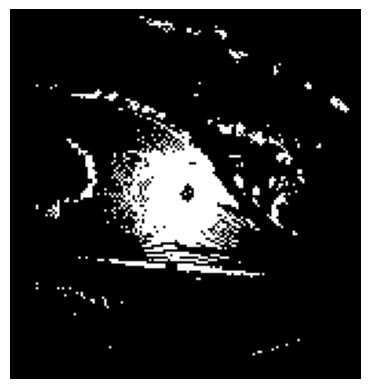

In [29]:
plt.imshow(occu, cmap = 'gray')
plt.axis('off')
plt.show()

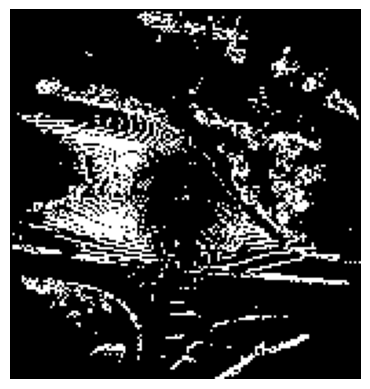

In [30]:
plt.imshow(free, cmap = 'gray')
plt.axis('off')
plt.show()

In [31]:
thresh = 10

for i in range(len(point_clouds)):
    grid = create_occupancy_grid(point_clouds[i])
    free = free_cells_grid(grid, thresh)
    occu = occupied_cells_grid(grid, thresh)
    path = f"results/4/1/free/{i+1}.png"
    plt.imshow(free, cmap = 'gray')
    plt.axis('off')
    plt.savefig(path)
    path = f"results/4/1/occupied/{i+1}.png"
    plt.imshow(occu, cmap = 'gray')
    plt.axis('off')
    plt.savefig(path)

2. Now, using the *registered* point cloud, generate occupancy maps for each frame. What difference do you expect to see between the two methods?

This method can provide a much better and reliable occupancy map, while covering a larger area, as the refernce point cloud is the result of concatenation of all the lidar scans

In [32]:
path_free = f"results/4/2/free_reference.png"
path_occu = f"results/4/2/occupied_reference.png"
grid = create_occupancy_grid(pcd_reference)
free = free_cells_grid(grid, 10)
occu = occupied_cells_grid(grid, 10)
plt.imshow(free, cmap = 'gray')
plt.axis('off')
plt.savefig(path_free)
plt.imshow(occu, cmap = 'gray')
plt.axis('off')
plt.savefig(path_occu)

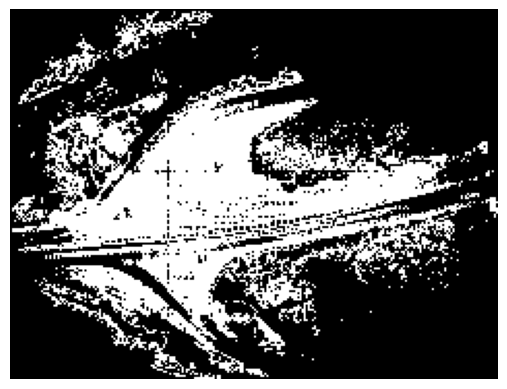

In [33]:
plt.imshow(free, cmap = 'gray')
plt.axis('off')
plt.show()

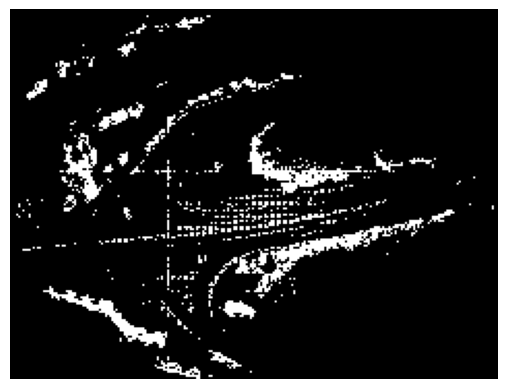

In [34]:
plt.imshow(occu, cmap = 'gray')
plt.axis('off')
plt.show()

In [35]:
thresh = 10

for i in range(len(pose_matrices)):
    path_free = f"results/4/2/free/{i+1}.png"
    path_occu = f"results/4/2/occupied/{i+1}.png"
    grid = create_occupancy_grid(change_camera_frame(pcd_reference, i))
    free = free_cells_grid(grid, thresh)
    occu = occupied_cells_grid(grid, thresh)
    plt.imshow(free, cmap = 'gray')
    plt.axis('off')
    plt.savefig(path_free)
    plt.imshow(occu, cmap = 'gray')
    plt.axis('off')
    plt.savefig(path_occu)